# Network Traffic Anomaly Detection Using Recurrent Neural Networks
## Replication File 1 of 6

Benjamin J. Radford, Leonardo M. Apolonio, Antonio J. Trias, and Jim A. Simpson

Paper available: [arXiv:1803.10769v1](https://arxiv.org/pdf/1803.10769.pdf).

DISTRIBUTION STATEMENT A: Approved for public release. 

This research was developed with funding from the Defense Advanced Research Projects Agency (DARPA). The views, opinions and/or findings expressed are those of the authors and should not be interpreted as representing the official views or policies of the Department of Defense or the U.S. Government.

In [1]:
import numpy as np
import pandas
import re
import h5py
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, auc, roc_curve
from keras.layers.core import Masking
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.layers.wrappers import Bidirectional
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Embedding, TimeDistributed
from keras.models import load_model
from tensorflow.python.client import device_lib
from lxml import etree
from itertools import groupby
from gensim.models import Word2Vec
import glob
import math
import itertools
from sklearn.metrics import *
import matplotlib.pyplot as plt

##
## Read in the raw ISCX IDS Data
##
print("Loading data...")
xml_list = glob.glob('data/labeled_flows_xml/*xml')

parser = etree.XMLParser(recover=True)

def xml2df(xml_data):
    root = etree.fromstring(xml_data, parser=parser) # element tree
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            record[subchild.tag] = subchild.text
            all_records.append(record)
    return pandas.DataFrame(all_records)

dfs = []
for ii in xml_list:
    xml_data = open(ii).read()
    dfs.append(xml2df(xml_data))

data = pandas.concat(dfs)
data = data.drop_duplicates()
del dfs

##
## Produce undirected IP-dyads and order by time
##
print("De-dup Flows: "+str(len(data)))
print("Creating undirected IP-dyads...")
data = data.sort_values('startDateTime')
data['seqId'] = data['source'] + '_' + data['destination'] + '_' + data['startDateTime'].str[:13]
data['lowPort'] = np.where(data.destinationPort <= data.sourcePort, data['destinationPort'], data['sourcePort'])

##
## Build hour-IP-dyad keys and sequences
##
print("Building sequences...")
key = data.groupby('seqId')[['Tag','lowPort']].agg({"Tag":lambda x: "%s" % ','.join([a for a in x]),"lowPort":lambda x: "%s" % ','.join([str(a) if int(a)<10000 else "10000" for a in x])})
print("Unique Keys: "+str(key.count()))
attacks = [a.split(",") for a in key.Tag.tolist()]
sequences = [a.split(",") for a in key.lowPort.tolist()]

##
## Create Label Encoder and add one to account for 0. masking
##
print("Generating Label Encoder...")
unique_tokens = list(set([a for b in sequences for a in b]))
le = LabelEncoder()
le.fit(unique_tokens)
sequences = [le.transform(s).tolist() for s in sequences]
sequences = [[b+1 for b in a] for a in sequences]

sequence_attack = zip(attacks, sequences)

##
## Build sequences
##
print("Generating sequences for model...")
na_value = 0.
seq_len = 10

seq_index = []
seq_x = []
seq_y = []
seq_attack = []
for si, (sa, ss) in enumerate(sequence_attack):
    prepend = [0.] * (seq_len)
    seq =  prepend + ss
    seqa = prepend + sa
    for ii in range(seq_len, len(seq)):
        subseq = seq[(ii-seq_len):(ii)]
        vex = []
        for ee in subseq:
            try:
                vex.append(ee)
            except:
                vex.append(na_value)
        seq_x.append(vex)
        seq_y.append(seq[ii])
        seq_index.append(si)
        seq_attack.append(seqa[ii])
        
##
## Make One-hot-encoder
##
print("Initializing One-hot-encoder...")
ohe = OneHotEncoder(sparse=False)
ohe.fit(np.unique(seq_y).reshape(-1,1))
X = np.array(seq_x)

##
## Generator for Batch Training
##
class BatchGenerator(object):
    def __init__(self, batch_size, x, y, ohe):
        self.batch_size = batch_size
        self.n_batches = int(math.floor(np.shape(x)[0] / batch_size))
        self.batch_index = [a * batch_size for a in range(0, self.n_batches)]
        self.x = x
        self.y = y
        self.ohe = ohe
        
    def __iter__(self):
        for bb in itertools.cycle(self.batch_index):
            y = self.y[bb:(bb+self.batch_size)]
            ohe_y = self.ohe.transform(y.reshape(len(y), 1))
            yield (self.x[bb:(bb+self.batch_size),], ohe_y)

Using TensorFlow backend.


Loading data...
De-dup Flows: 330111
Creating undirected IP-dyads...
Building sequences...
Unique Keys: lowPort    23973
Tag        23973
dtype: int64
Generating Label Encoder...
Generating sequences for model...
Initializing One-hot-encoder...


/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [2]:
##
## Define model
##
print("Defining model...")
model = Sequential()
model.add(Embedding(output_dim=100, input_dim=len(unique_tokens), mask_zero=True))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, activation="relu", return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50, activation="linear"))
model.add(Dropout(0.2))
model.add(Dense(len(unique_tokens), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

training_data = BatchGenerator(512, np.asarray(X), np.asarray(seq_y), ohe)

model.fit_generator(training_data.__iter__(),
    steps_per_epoch=training_data.n_batches,
    epochs=4, verbose=1)

Defining model...
Epoch 1/4
644/644 [==============================] - 338s 526ms/step - loss: 6.0262 - acc: 0.2156
Epoch 2/4
644/644 [==============================] - 313s 486ms/step - loss: 4.8027 - acc: 0.2358
Epoch 3/4
644/644 [==============================] - 310s 481ms/step - loss: 3.9489 - acc: 0.2661
Epoch 4/4
644/644 [==============================] - 308s 478ms/step - loss: 3.5356 - acc: 0.2891


In [3]:
model.save("models/ports_dirty.hd5")
model = load_model("models/ports_dirty.hd5")
preds = model.predict_proba(X, batch_size=512)

indexed_preds = zip(np.asarray(seq_index), preds, np.asarray(seq_y), np.asarray(seq_attack))

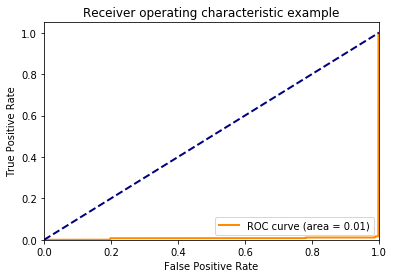

In [4]:
logloss_list = []
for (ii, pp, yy, aa) in indexed_preds:
    ll = -math.log(pp[yy-1]+1e-10)
    logloss_list.append(ll)

fpr, tpr, thresholds = roc_curve(np.asarray(seq_attack),logloss_list, pos_label="Attack")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

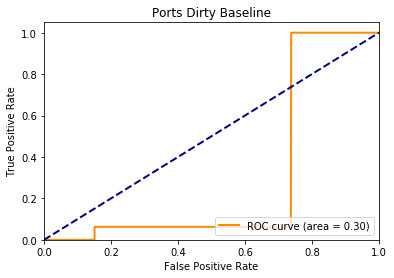

In [5]:
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.iteritems():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ports Dirty Baseline')
plt.legend(loc="lower right")
plt.savefig("graphics/ports_dirty_ipdyadhour-wise.pdf", format="pdf")
plt.show()